### IMPORT

In [14]:
import os
import time
import copy
from tqdm import tqdm
from PIL import Image
import torch
import random
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, models, datasets
from torch.cuda.amp import GradScaler, autocast
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import argparse
from contextlib import nullcontext
from PIL import ImageFile
import torch.nn.functional as F
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score


###  CLEANING + SPLIT DATASET (corn(1))


In [15]:

SOURCE_DIR = "/kaggle/input/corn1"
OUTPUT_DIR = "corn_clean_dataset"

TRAIN_SPLIT = 0.70
VAL_SPLIT   = 0.15
TEST_SPLIT  = 0.15

IMG_SIZE = (224, 224)
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Deteksi kelas = nama folder di dalam SOURCE_DIR (3 kelas)
class_names = sorted([
    d for d in os.listdir(SOURCE_DIR)
    if os.path.isdir(os.path.join(SOURCE_DIR, d))
])
print("Detected classes:", class_names)

# Buat folder output: train/val/test per kelas
for folder in ["train", "val", "test"]:
    for cls in class_names:
        os.makedirs(os.path.join(OUTPUT_DIR, folder, cls), exist_ok=True)

ImageFile.LOAD_TRUNCATED_IMAGES = True

MIN_BYTES = 1024 
def clean_and_save(src_path, dst_path):
    try:
        if os.path.getsize(src_path) < MIN_BYTES:
            return False

        with Image.open(src_path) as img:
            img = img.convert("RGB")
            img = img.resize(IMG_SIZE)

            # paksa output jadi .jpg biar pasti kebaca ImageFolder
            dst_path = os.path.splitext(dst_path)[0] + ".jpg"
            img.save(dst_path, format="JPEG", quality=95, optimize=True)

        return True
    except Exception:
        return False


def process_class(class_name):
    src_class = os.path.join(SOURCE_DIR, class_name)
    files = os.listdir(src_class)

    files = [f for f in files if f.lower().endswith((".jpg",".jpeg",".png",".bmp",".gif",".webp"))]
    random.shuffle(files)

    total = len(files)
    train_end = int(TRAIN_SPLIT * total)
    val_end   = train_end + int(VAL_SPLIT * total)

    train_files = files[:train_end]
    val_files   = files[train_end:val_end]
    test_files  = files[val_end:]  # sisa = test

    counters = {"train": 0, "val": 0, "test": 0}
    deleted = 0

    for file_list, folder in [(train_files, "train"), (val_files, "val"), (test_files, "test")]:
        for f in tqdm(file_list, desc=f"{class_name} → {folder}"):
            src_path = os.path.join(src_class, f)
            dst_path = os.path.join(OUTPUT_DIR, folder, class_name, f)

            ok = clean_and_save(src_path, dst_path)
            if ok:
                counters[folder] += 1
            else:
                deleted += 1

    print("\nClass:", class_name)
    print("Train :", counters["train"])
    print("Val   :", counters["val"])
    print("Test  :", counters["test"])
    print("Deleted (corrupt):", deleted)

for cls in class_names:
    process_class(cls)

print("\nCLEANING + SPLITTING SELESAI!")
print("Dataset akhir di:", OUTPUT_DIR)


Detected classes: ['Zea_mays_Chulpi_Cancha', 'Zea_mays_Indurata', 'Zea_mays_Rugosa']


Zea_mays_Chulpi_Cancha → test: 100%|██████████| 54/54 [00:00<00:00, 167.25it/s]



Class: Zea_mays_Chulpi_Cancha
Train : 244
Val   : 52
Test  : 54
Deleted (corrupt): 0


Zea_mays_Indurata → test: 100%|██████████| 54/54 [00:00<00:00, 164.68it/s]



Class: Zea_mays_Indurata
Train : 244
Val   : 52
Test  : 54
Deleted (corrupt): 0


Zea_mays_Rugosa → test: 100%|██████████| 54/54 [00:00<00:00, 169.34it/s]


Class: Zea_mays_Rugosa
Train : 244
Val   : 52
Test  : 54
Deleted (corrupt): 0

CLEANING + SPLITTING SELESAI!
Dataset akhir di: corn_clean_dataset


### ARGUMENTS, DEVICE, TRANSFORMS, DATALOADER


In [16]:

def get_args():
    parser = argparse.ArgumentParser(description="Train MobileNetV3Small on Corn Seed Dataset")
    parser.add_argument("--data_dir", type=str, default=OUTPUT_DIR,
                        help="Root folder with train/val/test subfolders")
    parser.add_argument("--output_dir", type=str, default="mobilenetv3_corn_output",
                        help="Where to save checkpoints and logs")
    parser.add_argument("--epochs", type=int, default=30)
    parser.add_argument("--batch_size", type=int, default=32)
    parser.add_argument("--img_size", type=int, default=224)
    parser.add_argument("--workers", type=int, default=4)
    parser.add_argument("--lr", type=float, default=0.001)
    parser.add_argument("--weight_decay", type=float, default=1e-4)
    parser.add_argument("--seed", type=int, default=42)
    parser.add_argument("--resume", type=str, default="", help="Path to checkpoint to resume (optional)")
    args = parser.parse_args([])
    return args

args = get_args()

torch.manual_seed(args.seed)
np.random.seed(args.seed)
random.seed(args.seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

os.makedirs(args.output_dir, exist_ok=True)

# Augmentation (jaga jangan terlalu brutal biar bentuk biji jagung tetap masuk akal)
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(args.img_size, scale=(0.75, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(8),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.10, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_test_transforms = transforms.Compose([
    transforms.Resize(int(args.img_size * 1.14)),
    transforms.CenterCrop(args.img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

train_dir = os.path.join(args.data_dir, "train")
val_dir   = os.path.join(args.data_dir, "val")
test_dir  = os.path.join(args.data_dir, "test")

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset   = datasets.ImageFolder(val_dir, transform=val_test_transforms)
test_dataset  = datasets.ImageFolder(test_dir, transform=val_test_transforms)

class_names = train_dataset.classes
print("Classes:", class_names)
print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))
print("Test samples:", len(test_dataset))

pin = True if device.type == "cuda" else False

train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True,
                          num_workers=args.workers, pin_memory=pin)
val_loader   = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False,
                          num_workers=args.workers, pin_memory=pin)
test_loader  = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False,
                          num_workers=args.workers, pin_memory=pin)


Device: cuda
Classes: ['Zea_mays_Chulpi_Cancha', 'Zea_mays_Indurata', 'Zea_mays_Rugosa']
Train samples: 732
Val samples: 156
Test samples: 162



### BUILD MODEL MobileNetV3Small + LOSS & OPTIMIZER


In [17]:


def build_model(num_classes, freeze_backbone=True, dropout_p=0.3):
    """
    MobileNetV3Small pretrained ImageNet.
    - freeze_backbone=True -> anti-overfitting utama (recommended untuk 1.050 gambar)
    """
    try:
        from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
        weights = MobileNet_V3_Small_Weights.IMAGENET1K_V1
        model = mobilenet_v3_small(weights=weights)
    except Exception:
        # fallback torchvision versi lama
        model = models.mobilenet_v3_small(pretrained=True)

    # freeze feature extractor (anti-overfit)
    if freeze_backbone:
        for p in model.features.parameters():
            p.requires_grad = False

    # ganti head classifier terakhir -> num_classes
    if isinstance(model.classifier, nn.Sequential):
        in_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(in_features, num_classes)

        # set dropout kalau ada dropout di classifier
        for m in model.classifier:
            if isinstance(m, nn.Dropout):
                m.p = dropout_p
    else:
        in_features = model.classifier.in_features
        model.classifier = nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(in_features, num_classes)
        )

    return model

model = build_model(len(class_names), freeze_backbone=True, dropout_p=0.3).to(device)

criterion = nn.CrossEntropyLoss()

# optimizer: hanya parameter yang requires_grad=True (head saja kalau backbone di-freeze)
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=args.lr,
    weight_decay=args.weight_decay
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

scaler = GradScaler(enabled=(device.type == "cuda"))
amp_ctx = autocast if device.type == "cuda" else nullcontext  # aman di CPU

start_epoch = 0
best_val_acc = 0.0

if args.resume:
    print("=> Loading checkpoint", args.resume)
    ckpt = torch.load(args.resume, map_location=device)
    model.load_state_dict(ckpt["model_state"])
    optimizer.load_state_dict(ckpt["optimizer_state"])
    scheduler.load_state_dict(ckpt.get("scheduler_state", scheduler.state_dict()))
    start_epoch = ckpt.get("epoch", 0) + 1
    best_val_acc = ckpt.get("best_val_acc", 0.0)
    print(f"=> Resumed from epoch {start_epoch}, best_val_acc={best_val_acc:.4f}")

/tmp/ipykernel_55/777532881.py:50: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device.type == "cuda"))


### TRAINING & VALIDATION LOOP


In [20]:
def train_one_epoch(epoch):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch} [Train]")
    for inputs, labels in pbar:
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with amp_ctx():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        if device.type == "cuda":
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).item()
        total += inputs.size(0)

        pbar.set_postfix(loss=running_loss/total, acc=running_corrects/total)

    return running_loss / total, running_corrects / total


def validate(epoch):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(val_loader, desc=f"Epoch {epoch} [Val]")
        for inputs, labels in pbar:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            with amp_ctx():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item()
            total += inputs.size(0)

            pbar.set_postfix(loss=running_loss/total, acc=running_corrects/total)

    return running_loss / total, running_corrects / total


def save_checkpoint(state, filename):
    torch.save(state, filename)


since = time.time()
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

best_model_wts = None

for epoch in range(start_epoch, args.epochs):
    train_loss, train_acc = train_one_epoch(epoch+1)
    val_loss, val_acc = validate(epoch+1)

    scheduler.step()

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}/{args.epochs}  "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}  |  "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    is_best = val_acc > best_val_acc
    if is_best:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    ckpt_path = os.path.join(args.output_dir, f"ckpt_epoch_{epoch+1}.pth")
    save_checkpoint({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scheduler_state": scheduler.state_dict(),
        "best_val_acc": best_val_acc,
    }, ckpt_path)


# ===== SAVE BEST + LAST =====
best_path = os.path.join(args.output_dir, "mobilenetv3small_best.pth")
last_path = os.path.join(args.output_dir, "mobilenetv3small_last.pth")

# BEST (berdasarkan val_acc)
if best_model_wts is not None:
    torch.save(best_model_wts, best_path)
    print("Best model saved to:", best_path)
else:
    torch.save(model.state_dict(), best_path)
    print("Best fallback (last) saved to:", best_path)

# LAST (epoch terakhir)
torch.save(model.state_dict(), last_path)
print("Last model saved to:", last_path)

time_elapsed = time.time() - since
print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s. "
      f"Best val acc: {best_val_acc:.4f}")


Epoch 1 [Train]:   0%|          | 0/23 [00:00<?, ?it/s]/tmp/ipykernel_55/1535502424.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp_ctx():
Epoch 1 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_55/1535502424.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp_ctx():
Epoch 1 [Val]: 100%|██████████| 5/5 [00:00<00:00, 12.97it/s, acc=1, loss=0.0798]


Epoch 1/30  Train Loss: 0.0808 Acc: 0.9686  |  Val Loss: 0.0798 Acc: 1.0000


Epoch 2 [Val]: 100%|██████████| 5/5 [00:00<00:00, 13.23it/s, acc=1, loss=0.0712]


Epoch 2/30  Train Loss: 0.0889 Acc: 0.9699  |  Val Loss: 0.0712 Acc: 1.0000


Epoch 3 [Val]: 100%|██████████| 5/5 [00:00<00:00, 13.41it/s, acc=0.987, loss=0.0658]


Epoch 3/30  Train Loss: 0.0680 Acc: 0.9727  |  Val Loss: 0.0658 Acc: 0.9872


Epoch 4 [Val]: 100%|██████████| 5/5 [00:00<00:00, 13.52it/s, acc=0.981, loss=0.0716]


Epoch 4/30  Train Loss: 0.0535 Acc: 0.9809  |  Val Loss: 0.0716 Acc: 0.9808


Epoch 5 [Val]: 100%|██████████| 5/5 [00:00<00:00, 13.35it/s, acc=0.981, loss=0.0614]


Epoch 5/30  Train Loss: 0.0570 Acc: 0.9836  |  Val Loss: 0.0614 Acc: 0.9808


Epoch 6 [Val]: 100%|██████████| 5/5 [00:00<00:00, 13.88it/s, acc=0.974, loss=0.0639]


Epoch 6/30  Train Loss: 0.0670 Acc: 0.9754  |  Val Loss: 0.0639 Acc: 0.9744


Epoch 7 [Val]: 100%|██████████| 5/5 [00:00<00:00, 13.61it/s, acc=0.968, loss=0.0628]


Epoch 7/30  Train Loss: 0.0550 Acc: 0.9809  |  Val Loss: 0.0628 Acc: 0.9679


Epoch 8 [Val]: 100%|██████████| 5/5 [00:00<00:00, 13.24it/s, acc=0.968, loss=0.0989]


Epoch 8/30  Train Loss: 0.0533 Acc: 0.9836  |  Val Loss: 0.0989 Acc: 0.9679


Epoch 9 [Val]: 100%|██████████| 5/5 [00:00<00:00, 13.36it/s, acc=0.968, loss=0.0944]


Epoch 9/30  Train Loss: 0.0535 Acc: 0.9781  |  Val Loss: 0.0944 Acc: 0.9679


Epoch 10 [Val]: 100%|██████████| 5/5 [00:00<00:00, 12.61it/s, acc=0.968, loss=0.0658]


Epoch 10/30  Train Loss: 0.0352 Acc: 0.9877  |  Val Loss: 0.0658 Acc: 0.9679


Epoch 11 [Val]: 100%|██████████| 5/5 [00:00<00:00, 13.17it/s, acc=0.962, loss=0.121]


Epoch 11/30  Train Loss: 0.0366 Acc: 0.9877  |  Val Loss: 0.1208 Acc: 0.9615


Epoch 12 [Val]: 100%|██████████| 5/5 [00:00<00:00, 13.36it/s, acc=0.981, loss=0.0438]


Epoch 12/30  Train Loss: 0.0530 Acc: 0.9795  |  Val Loss: 0.0438 Acc: 0.9808


Epoch 13 [Val]: 100%|██████████| 5/5 [00:00<00:00, 12.49it/s, acc=0.981, loss=0.0552]


Epoch 13/30  Train Loss: 0.0313 Acc: 0.9877  |  Val Loss: 0.0552 Acc: 0.9808


Epoch 14 [Val]: 100%|██████████| 5/5 [00:00<00:00, 13.18it/s, acc=0.981, loss=0.048] 


Epoch 14/30  Train Loss: 0.0330 Acc: 0.9932  |  Val Loss: 0.0480 Acc: 0.9808


Epoch 15 [Val]: 100%|██████████| 5/5 [00:00<00:00, 13.00it/s, acc=0.968, loss=0.0866]


Epoch 15/30  Train Loss: 0.0229 Acc: 0.9904  |  Val Loss: 0.0866 Acc: 0.9679


Epoch 16 [Val]: 100%|██████████| 5/5 [00:00<00:00, 11.62it/s, acc=0.968, loss=0.0762]


Epoch 16/30  Train Loss: 0.0302 Acc: 0.9850  |  Val Loss: 0.0762 Acc: 0.9679


Epoch 17 [Val]: 100%|██████████| 5/5 [00:00<00:00, 13.04it/s, acc=0.974, loss=0.0622]


Epoch 17/30  Train Loss: 0.0212 Acc: 0.9945  |  Val Loss: 0.0622 Acc: 0.9744


Epoch 18 [Val]: 100%|██████████| 5/5 [00:00<00:00, 12.89it/s, acc=0.981, loss=0.0542]


Epoch 18/30  Train Loss: 0.0226 Acc: 0.9918  |  Val Loss: 0.0542 Acc: 0.9808


Epoch 19 [Val]: 100%|██████████| 5/5 [00:00<00:00, 12.66it/s, acc=0.968, loss=0.0981]


Epoch 19/30  Train Loss: 0.0380 Acc: 0.9836  |  Val Loss: 0.0981 Acc: 0.9679


Epoch 20 [Val]: 100%|██████████| 5/5 [00:00<00:00, 13.38it/s, acc=1, loss=0.00493]


Epoch 20/30  Train Loss: 0.0673 Acc: 0.9754  |  Val Loss: 0.0049 Acc: 1.0000


Epoch 21 [Val]: 100%|██████████| 5/5 [00:00<00:00, 12.23it/s, acc=0.987, loss=0.0475]


Epoch 21/30  Train Loss: 0.0164 Acc: 0.9932  |  Val Loss: 0.0475 Acc: 0.9872


Epoch 22 [Val]: 100%|██████████| 5/5 [00:00<00:00, 12.76it/s, acc=0.987, loss=0.0673]


Epoch 22/30  Train Loss: 0.0537 Acc: 0.9850  |  Val Loss: 0.0673 Acc: 0.9872


Epoch 23 [Val]: 100%|██████████| 5/5 [00:00<00:00, 13.51it/s, acc=0.994, loss=0.00682]


Epoch 23/30  Train Loss: 0.0431 Acc: 0.9863  |  Val Loss: 0.0068 Acc: 0.9936


Epoch 24 [Val]: 100%|██████████| 5/5 [00:00<00:00, 13.10it/s, acc=1, loss=0.00239]


Epoch 24/30  Train Loss: 0.0343 Acc: 0.9891  |  Val Loss: 0.0024 Acc: 1.0000


Epoch 25 [Val]: 100%|██████████| 5/5 [00:00<00:00, 13.17it/s, acc=1, loss=0.00469]


Epoch 25/30  Train Loss: 0.0373 Acc: 0.9877  |  Val Loss: 0.0047 Acc: 1.0000


Epoch 26 [Val]: 100%|██████████| 5/5 [00:00<00:00, 13.27it/s, acc=0.994, loss=0.0111]


Epoch 26/30  Train Loss: 0.0216 Acc: 0.9932  |  Val Loss: 0.0111 Acc: 0.9936


Epoch 27 [Val]: 100%|██████████| 5/5 [00:00<00:00, 12.91it/s, acc=0.987, loss=0.0313]


Epoch 27/30  Train Loss: 0.0373 Acc: 0.9836  |  Val Loss: 0.0313 Acc: 0.9872


Epoch 28 [Val]: 100%|██████████| 5/5 [00:00<00:00, 12.76it/s, acc=0.994, loss=0.00665]


Epoch 28/30  Train Loss: 0.0234 Acc: 0.9932  |  Val Loss: 0.0066 Acc: 0.9936


Epoch 29 [Val]: 100%|██████████| 5/5 [00:00<00:00, 13.29it/s, acc=0.994, loss=0.0123]


Epoch 29/30  Train Loss: 0.0188 Acc: 0.9945  |  Val Loss: 0.0123 Acc: 0.9936


Epoch 30 [Val]: 100%|██████████| 5/5 [00:00<00:00, 13.45it/s, acc=0.987, loss=0.0479]


Epoch 30/30  Train Loss: 0.0448 Acc: 0.9836  |  Val Loss: 0.0479 Acc: 0.9872
Best model saved to: mobilenetv3_corn_output/mobilenetv3small_best.pth
Last model saved to: mobilenetv3_corn_output/mobilenetv3small_last.pth
Training complete in 1m 21s. Best val acc: 1.0000


### EVALUASI TEST SET + VISUALISASI


Test:   0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_55/1513903686.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp_ctx():
Test: 100%|██████████| 6/6 [00:00<00:00, 14.79it/s]


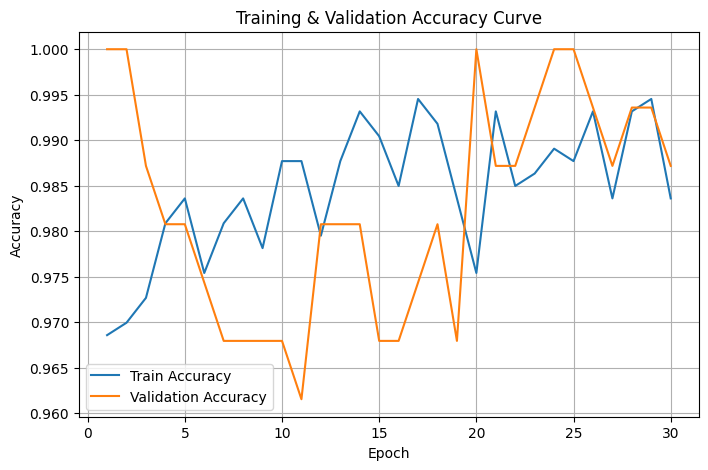

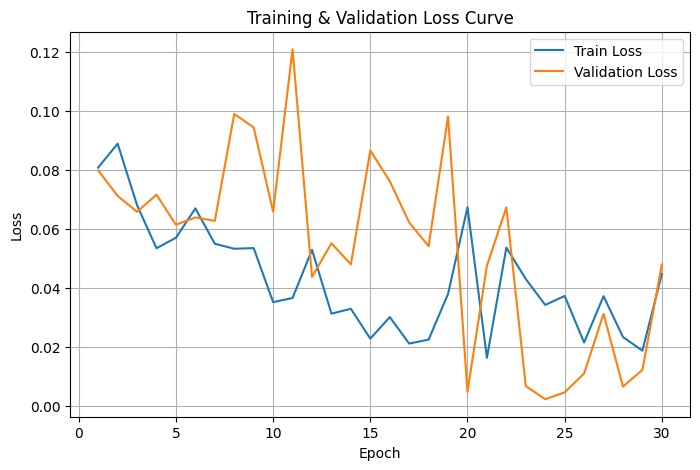

Test Accuracy: 0.9877
Classification Report:
                        precision    recall  f1-score   support

Zea_mays_Chulpi_Cancha       0.96      1.00      0.98        54
     Zea_mays_Indurata       1.00      1.00      1.00        54
       Zea_mays_Rugosa       1.00      0.96      0.98        54

              accuracy                           0.99       162
             macro avg       0.99      0.99      0.99       162
          weighted avg       0.99      0.99      0.99       162

ROC AUC per class:
- Zea_mays_Chulpi_Cancha: 0.9974
- Zea_mays_Indurata: 1.0000
- Zea_mays_Rugosa: 0.9976
Micro-Average ROC AUC: 0.9984
Macro-Average ROC AUC: 0.9983


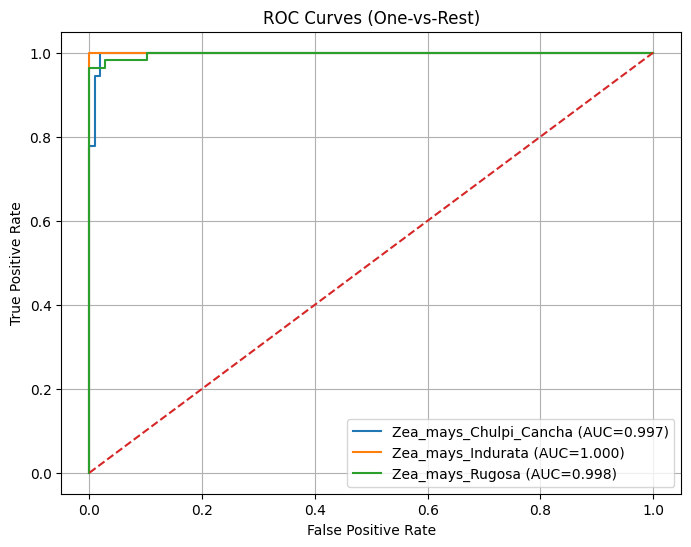

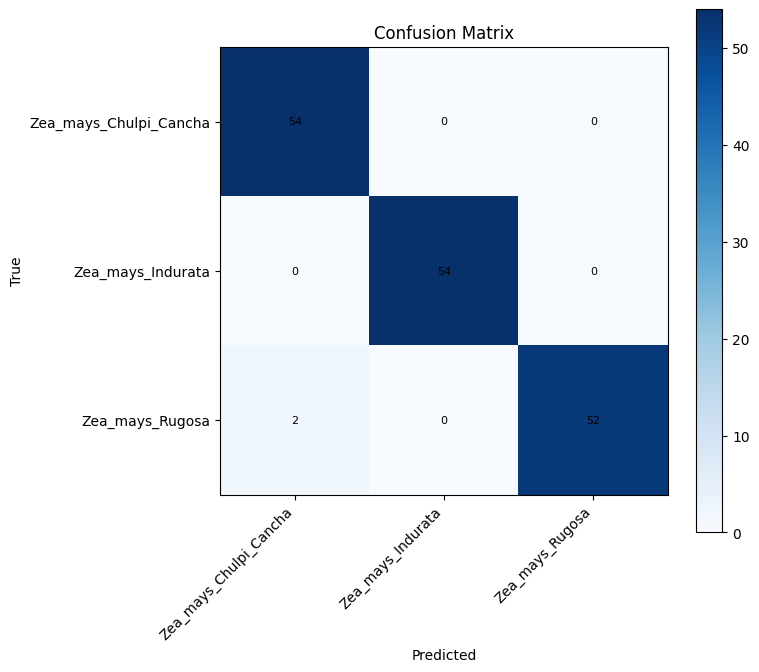

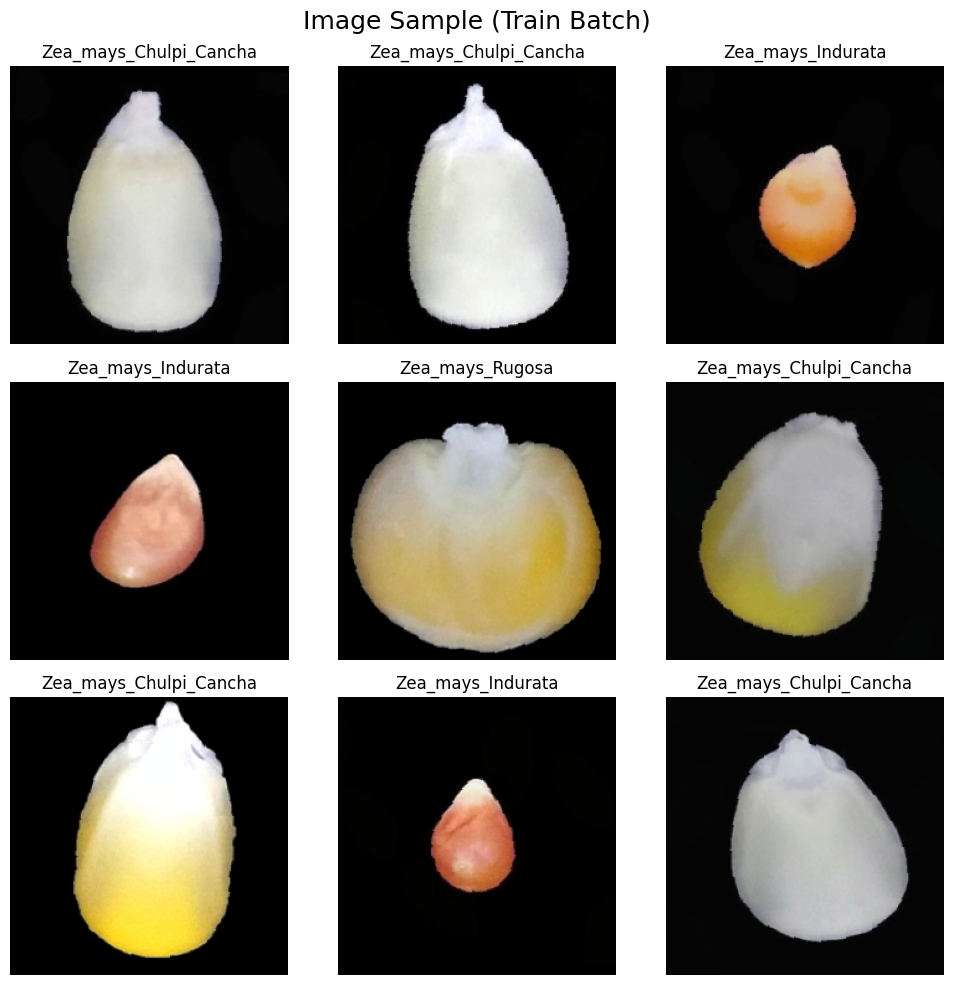

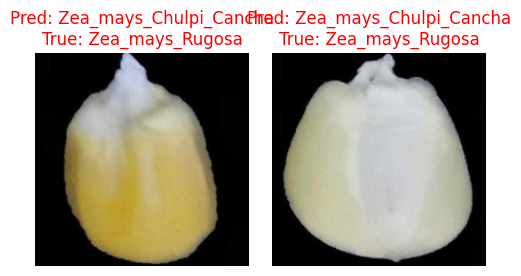

Test (LAST):   0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_55/1513903686.py:175: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp_ctx():
Test (LAST): 100%|██████████| 6/6 [00:00<00:00, 14.57it/s]


Test Accuracy (LAST): 1.0000
Classification Report (LAST):
                        precision    recall  f1-score   support

Zea_mays_Chulpi_Cancha       1.00      1.00      1.00        54
     Zea_mays_Indurata       1.00      1.00      1.00        54
       Zea_mays_Rugosa       1.00      1.00      1.00        54

              accuracy                           1.00       162
             macro avg       1.00      1.00      1.00       162
          weighted avg       1.00      1.00      1.00       162

ROC AUC per class (LAST):
- Zea_mays_Chulpi_Cancha: 1.0000
- Zea_mays_Indurata: 1.0000
- Zea_mays_Rugosa: 1.0000
Micro-Average ROC AUC (LAST): 1.0000
Macro-Average ROC AUC (LAST): 1.0000


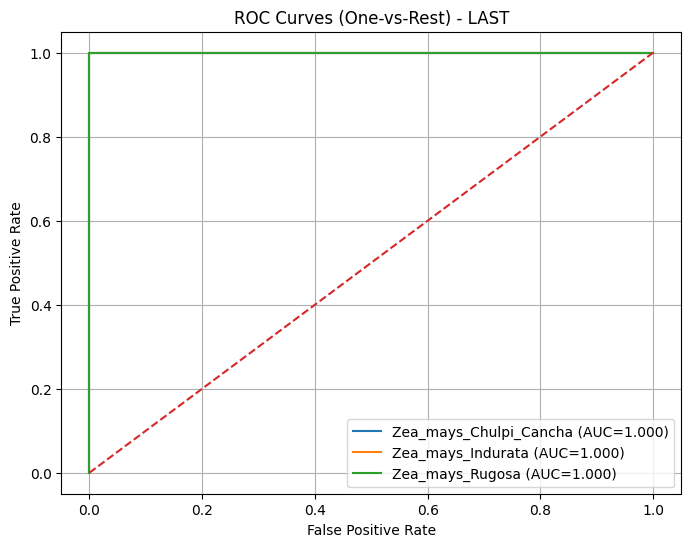

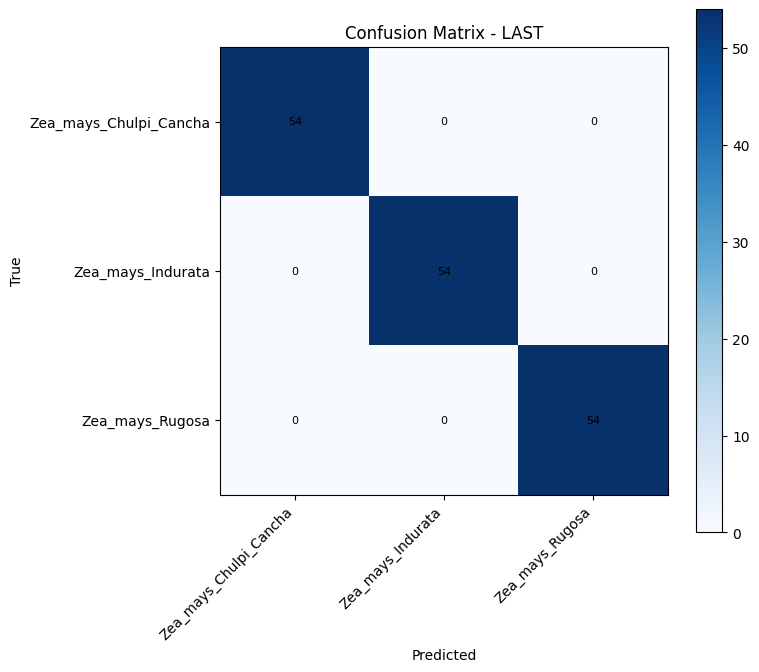

Tidak ada gambar yang salah prediksi!


In [21]:
model.load_state_dict(torch.load(best_path, map_location=device))
model = model.to(device)
model.eval()

all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    pbar = tqdm(test_loader, desc="Test")
    for inputs, labels in pbar:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with amp_ctx():
            outputs = model(inputs)

        probs = F.softmax(outputs, dim=1)          
        _, preds = torch.max(outputs, 1)

        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_probs = np.array(all_probs)
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
def plot_accuracy(train_acc, val_acc):
    epochs = range(1, len(train_acc) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_acc, label="Train Accuracy")
    plt.plot(epochs, val_acc, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_loss(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracy(history["train_acc"], history["val_acc"])
plot_loss(history["train_loss"], history["val_loss"])

print("Test Accuracy: {:.4f}".format(accuracy_score(all_labels, all_preds)))
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

n_classes = len(class_names)

y_true_bin = label_binarize(all_labels, classes=list(range(n_classes)))

fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

micro_auc = roc_auc_score(y_true_bin, all_probs, average="micro", multi_class="ovr")
macro_auc = roc_auc_score(y_true_bin, all_probs, average="macro", multi_class="ovr")

print("ROC AUC per class:")
for i in range(n_classes):
    print(f"- {class_names[i]}: {roc_auc[i]:.4f}")

print(f"Micro-Average ROC AUC: {micro_auc:.4f}")
print(f"Macro-Average ROC AUC: {macro_auc:.4f}")

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC={roc_auc[i]:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend()
plt.grid(True)
plt.show()

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,7))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black", fontsize=8)

plt.xticks(np.arange(len(class_names)), class_names, rotation=45, ha="right")
plt.yticks(np.arange(len(class_names)), class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# sample train batch
images, labels_batch = next(iter(train_loader))
plt.figure(figsize=(10,10))
plt.suptitle('Image Sample (Train Batch)', fontsize=18)

for i in range(min(9, len(images))):
    img = images[i].permute(1, 2, 0).cpu().numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)

    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(class_names[labels_batch[i]])
    plt.axis('off')

plt.tight_layout()
plt.show()

def show_misclassified(dataset, preds, labels, class_names, n=10):
    errors = [i for i in range(len(labels)) if preds[i] != labels[i]]
    if len(errors) == 0:
        print("Tidak ada gambar yang salah prediksi!")
        return

    idxs = errors[:n]
    plt.figure(figsize=(12, 12))

    for i, idx in enumerate(idxs):
        img, label = dataset[idx]
        pred = preds[idx]

        img = img.permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        plt.subplot(5, 5, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Pred: {class_names[pred]}\nTrue: {class_names[label]}",
                  color="red")

    plt.tight_layout()
    plt.show()

show_misclassified(test_dataset, all_preds, all_labels, class_names, n=10)


# =========================
# EVALUASI UNTUK LAST_PATH
# =========================

model.load_state_dict(torch.load(last_path, map_location=device))
model = model.to(device)
model.eval()

all_preds_last = []
all_labels_last = []
all_probs_last = []

with torch.no_grad():
    pbar = tqdm(test_loader, desc="Test (LAST)")
    for inputs, labels in pbar:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with amp_ctx():
            outputs = model(inputs)

        probs = F.softmax(outputs, dim=1)          
        _, preds = torch.max(outputs, 1)

        all_probs_last.extend(probs.cpu().numpy())
        all_preds_last.extend(preds.cpu().numpy())
        all_labels_last.extend(labels.cpu().numpy())

all_probs_last = np.array(all_probs_last)
all_preds_last = np.array(all_preds_last)
all_labels_last = np.array(all_labels_last)

print("Test Accuracy (LAST): {:.4f}".format(accuracy_score(all_labels_last, all_preds_last)))
print("Classification Report (LAST):")
print(classification_report(all_labels_last, all_preds_last, target_names=class_names))

n_classes = len(class_names)

y_true_bin_last = label_binarize(all_labels_last, classes=list(range(n_classes)))

fpr_last = {}
tpr_last = {}
roc_auc_last = {}

for i in range(n_classes):
    fpr_last[i], tpr_last[i], _ = roc_curve(y_true_bin_last[:, i], all_probs_last[:, i])
    roc_auc_last[i] = auc(fpr_last[i], tpr_last[i])

micro_auc_last = roc_auc_score(y_true_bin_last, all_probs_last, average="micro", multi_class="ovr")
macro_auc_last = roc_auc_score(y_true_bin_last, all_probs_last, average="macro", multi_class="ovr")

print("ROC AUC per class (LAST):")
for i in range(n_classes):
    print(f"- {class_names[i]}: {roc_auc_last[i]:.4f}")

print(f"Micro-Average ROC AUC (LAST): {micro_auc_last:.4f}")
print(f"Macro-Average ROC AUC (LAST): {macro_auc_last:.4f}")

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr_last[i], tpr_last[i], label=f"{class_names[i]} (AUC={roc_auc_last[i]:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest) - LAST")
plt.legend()
plt.grid(True)
plt.show()

cm_last = confusion_matrix(all_labels_last, all_preds_last)
plt.figure(figsize=(8,7))
plt.imshow(cm_last, cmap="Blues")
plt.title("Confusion Matrix - LAST")
plt.colorbar()

for i in range(cm_last.shape[0]):
    for j in range(cm_last.shape[1]):
        plt.text(j, i, cm_last[i, j], ha="center", va="center", color="black", fontsize=8)

plt.xticks(np.arange(len(class_names)), class_names, rotation=45, ha="right")
plt.yticks(np.arange(len(class_names)), class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

show_misclassified(test_dataset, all_preds_last, all_labels_last, class_names, n=10)
